In [1]:
import midi
import matplotlib.pyplot as plt
import argparse
import numpy as np
import os
import operator
import copy
from collections import defaultdict, deque
from heapq import *
import sklearn
from sklearn.cluster import DBSCAN

In [2]:
def interval_semitones(n1, n2):
    
    order = {'C':0, 'C#':1,'D':2,'D#':3,'E':4,'F':5,'F#':6,'G':7,'G#':8,'A':9,'A#':10,'B':11}
    
    note1 = str(Note(n1))[1:-1]
    note2 = str(Note(n2))[1:-1]
    
    t1 = note1.rfind('-')
    t2 = note2.rfind('-')
    
    l1 = note1[:t1]
    l2 = note2[:t2]
    
    oct1 = int(note1[t1 + 1:])
    oct2 = int(note2[t2 + 1:])
    

    if order[l1] < order[l2]:
        return 12 * (oct2 - oct1) + intervals.measure(l1, l2)
    else:
        return 12 * (oct2 - oct1) - intervals.measure(l2, l1)


In [149]:
for i in range(128):
    for j in range(128):
        if (i - j != interval_semitones(j,i)):
            print(i,j)

In [2]:
from collections import defaultdict
from heapq import *

def dijkstra(edges, f, t):
    g = defaultdict(list)
    for l,r,c in edges:
        g[l].append((c,r))

    q, seen, mins = [(0,f,())], set(), {f: 0}
    while q:
        (cost,v1,path) = heappop(q)
        if v1 not in seen:
            seen.add(v1)
            path = (v1, path)
            if v1 == t: return (cost, path)

            for c, v2 in g.get(v1, ()):
                if v2 in seen: continue
                prev = mins.get(v2, None)
                next = cost + c
                if prev is None or next < prev:
                    mins[v2] = next
                    heappush(q, (next, v2, path))

    return float("inf")


edges = [
    ("A", "B", 7),
    ("A", "D", 5),
    ("B", "C", 8),
    ("B", "D", 9),
    ("B", "E", 7),
    ("C", "E", 5),
    ("D", "E", 15),
    ("D", "F", 6),
    ("E", "F", 8),
    ("E", "G", 9),
    ("F", "G", 11)
]

print ("=== Dijkstra ===")
print (edges)
print ("A -> E:")
print (dijkstra(edges, "A", "E"))
print ("F -> E:")
print (dijkstra(edges, "F", "E"))

=== Dijkstra ===
[('A', 'B', 7), ('A', 'D', 5), ('B', 'C', 8), ('B', 'D', 9), ('B', 'E', 7), ('C', 'E', 5), ('D', 'E', 15), ('D', 'F', 6), ('E', 'F', 8), ('E', 'G', 9), ('F', 'G', 11)]
A -> E:
(14, ('E', ('B', ('A', ()))))
F -> E:
inf


In [ ]:
'''
i = 0

while(i < len(tr) - 1):

    curr_tick = tr[i].tick
    i_curr = i


    while(labels[i] == labels[i_curr]   and i < len(tr) - 1):
        i = i + 1



    pitch_new = 0
    candidates = sorted([tr[j].pitch for j in range(i_curr, i)])
    if i_curr > 0:
        if candidates[-1] == seq_pitch[-1] and len(candidates) > 1:
            pitch_new = candidates[-2]
        else:
            pitch_new = candidates[-1]
    else:
        pitch_new = candidates[-1]

    #length_new = min(lgs[0], tr[i].tick - curr_tick)
    length_new = min(min(lgs[0], tr[i_curr].length), tr[i].tick - curr_tick)

    def search(ln):
        L = [1,2,4,8,16]
        length_in_sxtns = int(np.round(ln / lgs[4]))

        if length_in_sxtns <= L[0]:
            return L[0]
        elif length_in_sxtns >= L[-1]:
            return L[0]
        else:
            for j in range(len(L) - 1):
                if length_in_sxtns > L[j] and length_in_sxtns <= L[j+1]:
                    if length_in_sxtns - L[j] > L[j + 1] - length_in_sxtns:
                        return L[j + 1]
                    else:
                        return L[j]



    length_in_sxtns = search(length_new)





    #print(pitch_new)

    seq_pitch = seq_pitch + [int(pitch_new)]
    seq_rythm = seq_rythm + [length_in_sxtns]

######################################################################################
#filter
seq_to_add = np.array([ seq_pitch[ii+1] - seq_pitch[ii]  for ii in range(len(seq_pitch) - 1)])
seq_to_add = np.array([x + 12 if np.abs(x) < 13 else 0 for x in seq_to_add])
if len(seq_rythm) > 50 and np.mean(seq_to_add == 0) < 0.45:
    GENERAL_BAG[1].append(seq_rythm[1:])
    GENERAL_BAG[0].append(list(seq_to_add))
    #print(number_of_track)

return GENERAL_BAG
'''

In [177]:
class Song:
           
    def __init__(self, name):
        
        self.song = midi.read_midifile(name)
        self.name = name
        self.res = self.song.resolution 

            
    def extract_collection(self):
        self.song.make_ticks_abs()
        tracks = []
        states = list(np.zeros(128))
        for track in self.song:
            
            notes = [note for note in track if note.name == 'Note On' or note.name == 'Note Off']
            notesoff = [note for note in track if note.name == 'Note Off']
            
            
            if len(notes) == 0:
                continue
                
            regime_indicator = len(notesoff) / float(len(notes))
            if (regime_indicator < 0.45):
                mode = 'trivial'
            else:
                mode = "non-trivial"
            
            
            
            list_of_notes = []
            
            
            if mode == "non-trivial":
                for note in notes:
                    if note.name == 'Note On':
                        states[note.pitch] = note.tick
                    else:

                        list_of_notes.append(MyNote(states[note.pitch], note.tick - states[note.pitch], note.pitch))
            else:
                
                previous_tick = notes[0].tick
                previous_pitch = notes[0].pitch
                
                for note in notes[1:]:
                    if note.name == 'Note On':
                        list_of_notes.append(MyNote(previous_tick, note.tick - previous_tick, previous_pitch))
                        previous_tick = note.tick
                        previous_pitch = note.pitch
               
            tracks.append(sorted(list_of_notes, key = operator.attrgetter('tick')))
                

        return tracks
    

def cut_and_lengths(sg):
    
    res = float(sg.res)
    GENERAL_BAG = [[],[]]
    
    lgs = [4 * res, 2 * res, res, res / 2, res / 4, res / 8, res / 16, res / 128]
    
    
    #print(res)

    
    for number_of_track, track in enumerate(sg.extract_collection()):
        
        tr = copy.copy(track)
        
        #plt.scatter([x.tick for x in tr], [x.pitch for x in tr], s = 1)
        #plt.show()
        #except bass
        #if (np.mean([x.pitch for x in tr]) < 60.0):#assure not to include bass
        #    continue
            
        seq_pitch = []
        seq_rythm = []
        
        db = DBSCAN(eps = lgs[5], min_samples=1)
        labels = db.fit_predict(np.array([[tr[i].tick] for i in range(len(tr))]))
        
        #plt.scatter([tr[i].tick for i in range(len(tr))], labels,c = labels)
        #plt.show()
        def dijkstra(edges, f, t):
            g = defaultdict(list)
            for l,r,c in edges:
                g[l].append((c,r))

            # dist records the min value of each node in heap.
            q, seen, dist = [(0,f,())], set(), {f: 0}
            while q:
                (cost,v1,path) = heappop(q)
                if v1 in seen: continue

                seen.add(v1)
                path += (v1,)
                if v1 == t: return (cost, path)

                for c, v2 in g.get(v1, ()):
                    if v2 in seen: continue

                    # Not every edge will be calculated. The edge which can improve the value of node in heap will be useful.
                    if v2 not in dist or cost+c < dist[v2]:
                        dist[v2] = cost+c
                        heappush(q, (cost+c, v2, path))

            return float("inf")
        


        edges = [ ("f", "0-" + str(tr[i].pitch), 0) for i in range(len(tr)) if labels[i] == 0 \
            ] + [(str(np.max(labels)) + "-" + str(tr[i].pitch), "t" , 0) for i in range(len(tr))\
                 if labels[i] == np.max(labels) ]

        
        vertex_dict = {k:set() for k in range(np.max(labels) + 1)}
        
        for k in range(len(labels)):
            vertex_dict[labels[k]].add(tr[k].pitch)
        
        def custom_distance(c1, c2):
            dist = c2 - c1
            if dist == 0.0:
                return 200 - c2#5 + 200 - c2
            elif np.abs(dist) < 12:
                return np.abs(dist)
            else:
                if dist < 0:
                    return 200 - c2#12 + (-dist) % 12 + 200 - c2
                else:
                    return 200 - c2#12 + dist % 12 + 200 - c2
                            
            
        for cluster in range(np.max(labels)):
            for c1 in vertex_dict[cluster]:
                for c2 in vertex_dict[cluster + 1]:
                    edges.append((str(cluster) + "-" + str(c1), str(cluster + 1) + "-" + str(c2), custom_distance(c1, c2)))

        
        distnce, path = dijkstra(edges, "f", "t")
        
        
        #print(np.max(labels) + 1)
        #print(path)
        ticks_dict = {k:set() for k in range(np.max(labels) + 1)}
        
        for k in range(len(labels)):
            ticks_dict[labels[k]].add(tr[k].tick)
            
        ticks = np.array([np.mean(list(ticks_dict[k])) for k in range(np.max(labels) + 1)])
        ticks = list(ticks[1:] - ticks[:-1])
        
        def search(ln):
            L = [1,2,4,8,16]
            length_in_sxtns = int(np.round(ln / lgs[4]))

            if length_in_sxtns <= L[0]:
                return L[0]
            elif length_in_sxtns >= L[-1]:
                return L[0]
            else:
                for j in range(len(L) - 1):
                    if length_in_sxtns > L[j] and length_in_sxtns <= L[j+1]:
                        if length_in_sxtns - L[j] > L[j + 1] - length_in_sxtns:
                            return L[j + 1]
                        else:
                            return L[j]
                                      
                                     
        
        lengths = [search(min(lgs[0], x)) for x in ticks]
        
        pitches = np.array([int(x.split("-")[1]) for x in list(path)[1:-1]])
        pitches = pitches[1:] - pitches[:-1]
        
        def transform_pitch(x):
            if np.abs(x) < 12:
                return x
            else:
                if x < 0:
                    return -((-x) % 12) - 12
                else:
                    return 12 + x % 12
                
        pitches = [transform_pitch(x) + 23 for x in pitches]
        #pitches = [x + 23  for x in pitches]#if np.abs(x) < 13 else 0
        
        if len(lengths) > 13 and np.mean(np.array(pitches) == 23) < 0.25:
            GENERAL_BAG[1].append(lengths)
            GENERAL_BAG[0].append(pitches)
    

        
        assert(len(lengths) == len(pitches))
        
        #print(len(lengths) , len(pitches))
        
    return GENERAL_BAG

        

            
    
    


In [70]:
-12-(12-(-24 % 12))

-24

In [71]:
-43 % 12

5

<IPython.core.display.Javascript object>


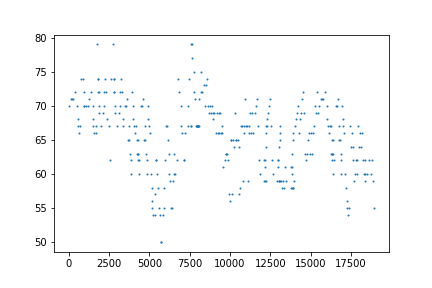

0


In [145]:
GB = cut_and_lengths(Song("chpn.mid"))

GENERAL_BAG_pitch =  GB[0]
GENERAL_BAG_rythm = GB[1]

ntrack = 0
                 
create_track_new(GENERAL_BAG_rythm[ntrack],GENERAL_BAG_pitch[ntrack])

In [ ]:
int(np.floor(np.log2(1.0 / length_in_sxtns))) + 6

In [155]:
Note(69)

'A-5'

In [5]:
class MyNote:
    def __init__(self,t,l,p):
        self.pitch = p
        self.length = l
        self.tick = t

In [95]:
from midiutil import MIDIFile
import matplotlib.pyplot as plt


def create_track_new(seq, seq_pitch):
    
    #num_to_len = {1:1, 2:2, 3:4, 4:8, 5:16, 6:32}
    grain = 8
    one_tact = 128
    tacts_per_min = 75
    tempo    = one_tact * tacts_per_min  # In BPM
    volume   = 100  # 0-127, as per the MIDI standard
    track    = 0
    channel  = 0
    time     = 0# to learn
    
    MyMIDI = MIDIFile(1)
    MyMIDI.addTempo(track, time, tempo)
    
    MyMIDI.addNote(track, channel, 120, 0, one_tact / grain, volume)
    tick_count = one_tact / grain
    
    current_pitch = 70
    
    tick_counts = [tick_count]
    pitches = [current_pitch]
    
    #decode_lengths  = {0:1, 1:2, 2:4, 3:8, 4:16}
    for l,p in zip(seq, seq_pitch):
        current_pitch += (p - 23)
        if current_pitch < 20:
            current_pitch += 50
        if current_pitch > 100:
            current_pitch -= 50
        pitches += [current_pitch]
        #length = num_to_len[l]
        #print(l)
        MyMIDI.addNote(track, channel, current_pitch, tick_count, one_tact / grain * (l), volume)
        tick_count = tick_count + one_tact / grain * (l)
        tick_counts += [tick_count]
    
    plt.scatter(tick_counts, pitches, s = 1)
    plt.show()
    print(track)

    with open("zzz.mid", "wb") as output_file:
        MyMIDI.writeFile(output_file) 
                
               



In [41]:
np.mean(list({1,2,3}))

2.0

In [126]:
np.mean(np.array(GENERAL_BAG_pitch[ntrack]) == 23)

0.1652754590984975

<IPython.core.display.Javascript object>


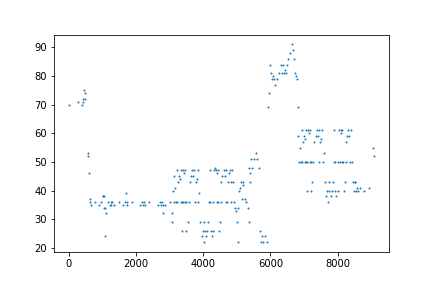

0


In [191]:
ntrack = 1224
create_track_new(GENERAL_BAG_rythm[ntrack],GENERAL_BAG_pitch[ntrack])

<IPython.core.display.Javascript object>


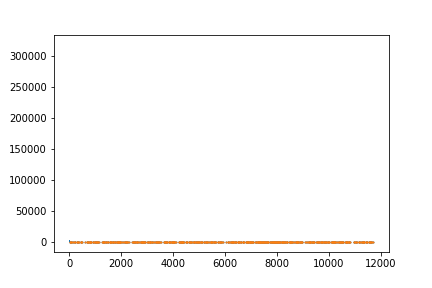

(array([   373.,    432.,    684.,    667.,   1361.,   1238.,   1685.,
          2644.,   3968.,   6022.,   4168.,  15261.,   3725.,   5390.,
         14225.,   8961.,  31722.,  19283.,  44368.,  44779.,  59156.,
        100078.,  94877., 317985.,  95571.,  93907.,  63891.,  46174.,
         47513.,  20053.,  31892.,   8086.,  12888.,   5754.,   4234.,
         14066.,   6467.,   4616.,   3244.,   2411.,   1599.,    945.,
          1512.,    647.,    811.,    542.,    425.]),
 array([ 0.        ,  0.9787234 ,  1.95744681,  2.93617021,  3.91489362,
         4.89361702,  5.87234043,  6.85106383,  7.82978723,  8.80851064,
         9.78723404, 10.76595745, 11.74468085, 12.72340426, 13.70212766,
        14.68085106, 15.65957447, 16.63829787, 17.61702128, 18.59574468,
        19.57446809, 20.55319149, 21.53191489, 22.5106383 , 23.4893617 ,
        24.46808511, 25.44680851, 26.42553191, 27.40425532, 28.38297872,
        29.36170213, 30.34042553, 31.31914894, 32.29787234, 33.27659574,
        

In [106]:
plt.hist(reduce(lambda x,y:x+y,GENERAL_BAG_pitch), bins = 47)

In [262]:
int(np.ceil(np.log2(0.33)))

-1

In [277]:
int(-1.0)

-1

In [ ]:
[np.mean(np.array(GENERAL_BAG_rythm[i]) == 6) for i in range(len(GENERAL_BAG_rythm))]

In [178]:
%matplotlib notebook
GENERAL_BAG_pitch = []
GENERAL_BAG_rythm = []

for name in os.listdir("C:/Users/Charles/Documents/Sergey/Music Generation Project/2"):
    #print(name)
    if ".mid" in name:
        GB = cut_and_lengths(Song(name))

        GENERAL_BAG_pitch = GENERAL_BAG_pitch + GB[0]
        GENERAL_BAG_rythm = GENERAL_BAG_rythm + GB[1]
        


In [10]:
IPython.display.Audio('zzz.mid')

NameError: name 'IPython' is not defined

In [120]:
len(GENERAL_BAG_rythm)

1642

In [192]:
import pickle
with open("jazz_pitch.txt", "wb") as fp:   #Pickling
    pickle.dump(GENERAL_BAG_pitch, fp)

In [193]:
with open("jazz_rythm.txt", "wb") as fp:   #Pickling
    pickle.dump(GENERAL_BAG_rythm, fp)

In [101]:
set(reduce(lambda x,y:x+y,GENERAL_BAG_pitch))

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46}

In [109]:
len(GENERAL_BAG_pitch)

2627

In [213]:
for x,y in zip(GENERAL_BAG_pitch, GENERAL_BAG_rythm):
    if len(x) != len(y):
        print(len(x), len(y))

In [215]:
GENERAL_BAG_rythm[0]

[1,
 7.0,
 1.0,
 1,
 1,
 1,
 1.0,
 1,
 1,
 1,
 8.0,
 1,
 1,
 1.0,
 1,
 1.0,
 1,
 1,
 1.0,
 1.0,
 1.0,
 1,
 1,
 1,
 1,
 1.0,
 2.0,
 1,
 1,
 7.0,
 1,
 1,
 1,
 1,
 1.0,
 1.0,
 1,
 6.0,
 1,
 1,
 1,
 1,
 1,
 1,
 7.0,
 1,
 2.0,
 1.0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 7.0,
 1,
 1.0,
 1,
 3.0,
 2.0,
 1,
 1,
 8.0,
 1.0,
 1,
 1,
 5.0,
 1,
 1,
 2.0,
 2.0,
 1,
 1,
 1,
 1,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1,
 5.0,
 1.0,
 1,
 6.0,
 1,
 2.0,
 1,
 1,
 7.0,
 1,
 1,
 1,
 1,
 2.0,
 1,
 1,
 1,
 4.0,
 1,
 1,
 1.0,
 1,
 1.0,
 1,
 1,
 1,
 1,
 2.0,
 1.0,
 1,
 1,
 1.0,
 1,
 1,
 1,
 1,
 1,
 1.0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2.0,
 1,
 1,
 2.0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2.0,
 1,
 1,
 1,
 2.0,
 1,
 1,
 1,
 3.0,
 1,
 1,
 1,
 1,
 1,
 1.0,
 1,
 1,
 1,
 1.0,
 1,
 1,
 1,
 1,
 1,
 1,
 3.0,
 1,
 1,
 2.0,
 1,
 1,
 1,
 1.0,
 1,
 1,
 1.0,
 1.0,
 1,
 1,
 1.0,
 2.0,
 1,
 1,
 1,
 1.0,
 1,
 5.0,
 1,
 1,
 1,
 1,
 1,
 2.0,
 1.0,
 1,
 1.0,
 1,
 1,
 1,
 1,
 1.0,
 1,
 1,
 1.0,
 1,
 1,
 1,
 1.0,
 1,
 1,
 5.0,
 1,
 1,
 1,
 1.0,
 1,
 1,
 1

In [172]:
import IPython

In [7]:
import mingus.core.intervals as intervals

In [40]:
"c-10".rfind('-')

1

In [46]:
intervals.measure('F#','C')

6

In [8]:
Note(127)

NameError: name 'Note' is not defined

In [9]:
from mingus.containers import Note

In [15]:
for i in range(24,40):
    print(str(Note(i))[1:-1])

C-2
C#-2
D-2
D#-2
E-2
F-2
F#-2
G-2
G#-2
A-2
A#-2
B-2
C-3
C#-3
D-3
D#-3


In [55]:
class Event:
    
    def __init__(self, ti, p, t):
        self.tick = ti
        self.pitch = p
        self.type = t
        
def create_track(seq):
    pattern = midi.Pattern()
    pattern.resolution = 960
    track = midi.Track()
    pattern.append(track)
    events = []
    
    for note in seq:
        events.append(Event(note.tick, note.pitch, "On"))
        events.append(Event(note.tick + 4 * pattern.resolution / note.length, note.pitch, "Off"))
    
    events = sorted(events, key = operator.attrgetter('tick'))
    intercept = events[0].tick
    
    track.append(midi.TimeSignatureEvent(tick=0, data=[4, 4, 30, 8]))
    track.append(midi.SetTempoEvent(tick=0, data=[7, 161, 32]))

    for e in events:
        if e.type == "On":
            n = midi.NoteOnEvent(tick = e.tick - intercept, velocity = 20, pitch = e.pitch)
            track.append(n)
        else:
            n = midi.NoteOffEvent(tick = e.tick - intercept, velocity = 20, pitch = e.pitch)
            track.append(n)
    
    eot = midi.EndOfTrackEvent(tick=1)
    track.append(eot)
    
    print(track)

    midi.write_midifile("XXX.mid", pattern)
    

In [83]:
len(GENERAL_BAG_pitch)

2611

In [142]:
filtered = [i for i in range(len(GENERAL_BAG_pitch)) if np.max(np.abs(GENERAL_BAG_pitch[i])) < 25 and len(GENERAL_BAG_pitch[i]) > 50]

In [ ]:
[np.mean(np.abs(np.array(GENERAL_BAG_pitch[i])) > 50) for i in range(len(GENERAL_BAG_pitch)) if len(GENERAL_BAG_pitch[i]) > 50]

In [66]:
np.abs([-1,2,3])

array([1, 2, 3])

In [52]:
GENERAL_BAG_rythm[0]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [75]:
GENERAL_BAG_pitch[0]

[-5,
 5,
 0,
 -8,
 4,
 1,
 0,
 0,
 -2,
 0,
 -7,
 5,
 7,
 0,
 5,
 0,
 -5,
 -2,
 -7,
 0,
 12,
 0,
 0,
 -7,
 0,
 0,
 5,
 0,
 -5,
 -6,
 5,
 0,
 0,
 -3,
 0,
 0,
 12,
 -7,
 0,
 0,
 -4,
 2,
 0,
 0,
 -7,
 7,
 5,
 0,
 0,
 -13,
 12,
 -3,
 1,
 0,
 0,
 -7,
 4,
 1,
 0,
 0,
 -6,
 6,
 -7,
 5,
 7,
 7,
 1,
 -3,
 0,
 -5,
 -2,
 -7,
 0,
 -1,
 1,
 -3,
 2,
 1,
 10,
 0,
 -1,
 0,
 -4,
 0,
 0,
 -5,
 5,
 5,
 0,
 -4,
 -7,
 4,
 1,
 0,
 0,
 -3,
 0,
 0,
 12,
 -7,
 0,
 0,
 -4,
 2,
 0,
 5,
 12,
 -3,
 -2,
 -3,
 0,
 0,
 0,
 -10,
 5,
 0,
 -5,
 1,
 1,
 1,
 -5,
 -7,
 7,
 5,
 2,
 1,
 0,
 -5,
 0,
 0,
 -1,
 1,
 -5,
 2,
 1,
 4,
 1,
 0,
 1,
 1,
 3,
 2,
 -9,
 0,
 -3,
 0,
 -7,
 7,
 5,
 0,
 -7,
 -1,
 -4,
 4,
 -2,
 2,
 1,
 12,
 0,
 -7,
 0,
 0,
 -12,
 5,
 2,
 3,
 0,
 7,
 -12,
 7,
 0,
 1,
 5,
 0,
 -5,
 -2,
 0,
 0,
 -3,
 0,
 15,
 2,
 0,
 -24,
 5,
 3,
 2,
 2,
 2,
 3,
 0,
 0,
 2,
 1,
 1,
 0,
 -7,
 0,
 0,
 0,
 -5,
 2,
 1,
 0,
 -5,
 -7,
 14,
 -6,
 -8,
 7,
 5,
 -2,
 0,
 0,
 0,
 -3,
 0,
 0,
 1,
 4,
 3,
 4,
 1,
 2,
 1,
 0,
 -8,
 -8,
 1,
 0,

In [36]:
len(GENERAL_BAG[0][1]) - len(GENERAL_BAG[0][0])

0

In [48]:
GENERAL_BAG_pitch[i]

[]

In [17]:
l = [len(x) for x in GENERAL_BAG]
len(l)

1086

In [18]:
l

[7,
 7,
 8,
 8,
 1,
 1,
 9,
 9,
 4,
 4,
 1,
 1,
 16,
 16,
 3,
 3,
 4,
 4,
 1,
 1,
 1,
 1,
 7,
 7,
 1,
 1,
 1,
 1,
 9,
 9,
 8,
 8,
 3,
 3,
 1,
 1,
 1,
 1,
 22,
 22,
 5,
 5,
 7,
 7,
 8,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 6,
 3,
 3,
 19,
 19,
 1,
 1,
 6,
 6,
 3,
 3,
 2,
 2,
 3,
 3,
 1,
 1,
 16,
 16,
 9,
 9,
 6,
 6,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 17,
 17,
 13,
 13,
 13,
 13,
 1,
 1,
 3,
 3,
 3,
 3,
 1,
 1,
 1,
 1,
 4,
 4,
 9,
 9,
 6,
 6,
 20,
 20,
 1,
 1,
 1,
 1,
 5,
 5,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 5,
 5,
 1,
 1,
 6,
 6,
 1,
 1,
 4,
 4,
 4,
 4,
 19,
 19,
 8,
 8,
 6,
 6,
 12,
 12,
 17,
 17,
 1,
 1,
 5,
 5,
 8,
 8,
 13,
 13,
 7,
 7,
 13,
 13,
 1,
 1,
 4,
 4,
 3,
 3,
 10,
 10,
 1,
 1,
 9,
 9,
 9,
 9,
 6,
 6,
 4,
 4,
 5,
 5,
 1,
 1,
 1,
 1,
 13,
 13,
 16,
 16,
 12,
 12,
 1,
 1,
 12,
 12,
 1,
 1,
 15,
 15,
 7,
 7,
 7,
 7,
 1,
 1,
 6,
 6,
 1,
 1,
 3,
 3,
 9,
 9,
 4,
 4,
 8,
 8,
 15,
 15,
 1,
 1,
 1,
 1,
 18,
 18,
 3,
 3,
 3,
 3,
 15,
 15,
 9,


In [64]:
GB = [x for x in GENERAL_BAG if len(x) >= 50]

In [35]:
l = [len(x) for x in GENERAL_BAG if len(x) > 50]


In [58]:
GB[220]


[53,
 55,
 56,
 58,
 56,
 55,
 53,
 56,
 1,
 56,
 55,
 48,
 1,
 55,
 58,
 1,
 58,
 1,
 58,
 59,
 1,
 59,
 1,
 59,
 59,
 1,
 51,
 53,
 1,
 53,
 1,
 1,
 1,
 1,
 1,
 0,
 51,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 49,
 49,
 1,
 44,
 1,
 1,
 1,
 53,
 1,
 54,
 53,
 1,
 1,
 1,
 0,
 53,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 53,
 55,
 56,
 58,
 56,
 55,
 53,
 56,
 1,
 56,
 55,
 48,
 1,
 55,
 58,
 1,
 58,
 1,
 58,
 59,
 1,
 59,
 1,
 59,
 59,
 1,
 51,
 53,
 1,
 53,
 1,
 1,
 1,
 1,
 1,
 0,
 51,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 49,
 49,
 1,
 44,
 1,
 1,
 1,
 53,
 1,
 54,
 53,
 1,
 1,
 1,
 0,
 53,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 55,
 1,
 1,
 1,
 1,
 55,
 51,
 48,
 1,
 1,
 48,
 1,
 58,
 56,
 53,
 55,
 1,
 1,
 1,
 1,
 55,
 51,
 48,
 1,
 1,
 48,
 1,
 58,
 56,
 53,
 55,
 1,
 1,
 1,
 1,
 55,
 51,
 48,
 1,
 1,
 48,
 1,
 58,
 56,
 53,
 55,
 1,
 1,
 1,
 1,
 55,
 51,
 48,
 1,
 1,
 48,
 1,
 58,
 56,
 53,
 48,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 48,
 1,
 1,
 1

In [75]:
create_track_new(GB[2000])

0


In [96]:
GB = [x for x in GENERAL_BAG if len(x) > 40]

In [101]:
max([min([y for y in x if y > 0]) for x in GB])

33

In [102]:
max([max(x) for x in GB])

107

In [ ]:
l = []



In [13]:
def note_to_state(n):
    return str(n.pitch) + "/" + str(n.length)

In [14]:
State_set = [str(x) + "/" + str(y) for x in range(24,97,1) for y in [1, 2, 4, 8, 16, 32, 64]]

In [15]:
State_dict = {State_set[i] : i for i in range(len(State_set))}

In [50]:
STATES = [[note_to_state(n) for n in x] for x in GENERAL_BAG]

In [51]:
q = sum(STATES,[])
int_to_notes = dict(enumerate(set(q)))
notes_to_int = {int_to_notes[x]:x for x in int_to_notes.keys()}

In [52]:
STATES_INTS = [[notes_to_int[x] for x in y] for y in STATES]

In [54]:
notes_to_int

{'0/8': 268,
 '1/64': 27,
 '100/16': 456,
 '100/32': 605,
 '100/4': 178,
 '100/64': 371,
 '100/8': 114,
 '101/1': 60,
 '101/16': 422,
 '101/2': 62,
 '101/32': 154,
 '101/4': 66,
 '101/64': 250,
 '101/8': 109,
 '102/16': 444,
 '102/32': 152,
 '102/64': 20,
 '102/8': 133,
 '103/1': 117,
 '103/16': 455,
 '103/2': 102,
 '103/32': 30,
 '103/4': 115,
 '103/64': 466,
 '103/8': 129,
 '104/16': 283,
 '104/2': 493,
 '104/32': 175,
 '104/4': 139,
 '104/64': 70,
 '104/8': 137,
 '105/16': 405,
 '105/32': 147,
 '105/4': 132,
 '105/64': 390,
 '105/8': 264,
 '106/16': 582,
 '106/32': 49,
 '106/64': 413,
 '106/8': 145,
 '107/16': 408,
 '107/32': 56,
 '107/4': 146,
 '107/64': 134,
 '107/8': 141,
 '108/16': 427,
 '108/2': 51,
 '108/32': 160,
 '108/4': 52,
 '108/64': 533,
 '108/8': 407,
 '109/32': 179,
 '109/64': 263,
 '11/64': 391,
 '110/32': 10,
 '110/64': 562,
 '111/32': 384,
 '111/64': 63,
 '112/16': 521,
 '112/32': 246,
 '112/64': 499,
 '113/32': 265,
 '113/64': 173,
 '114/32': 303,
 '114/64': 554,
 

In [31]:
with open("jazz123.txt", "wb") as fp:   #Pickling
    pickle.dump(GENERAL_BAG, fp)#pickle.dump(STATES_INTS, fp)

# Auxiliary Part

In [26]:
def parse_note(n):
    ind = n.find('/')
    return (int(n[:ind]), int(n[ind+1:]))

In [74]:
L = ['61/64',
 '94/8',
 '42/4',
 '22/2',
 '49/4',
 '44/1',
 '52/4',
 '25/1',
 '79/4',
 '31/32',
 '66/16',
 '25/1',
 '90/8',
 '66/16',
 '90/8',
 '79/4',
 '66/16',
 '91/8',
 '94/4',
 '90/8',
 '26/1',
 '79/4',
 '43/1',
 '43/8',
 '35/4']


GEN_TRACK = []

t = 0
for p,l in [parse_note(x) for x in L]:
    delta = 196*4 / l
    GEN_TRACK.append(Note(t, l , p))
    t += delta 

create_track(GEN_TRACK)

midi.Track(\
  [midi.TimeSignatureEvent(tick=0, data=[4, 4, 24, 8]),
   midi.SetTempoEvent(tick=0, data=[3, 1, 1]),
   midi.NoteOnEvent(tick=0, channel=0, data=[61, 20]),
   midi.NoteOnEvent(tick=12, channel=0, data=[94, 20]),
   midi.NoteOffEvent(tick=60, channel=0, data=[61, 20]),
   midi.NoteOnEvent(tick=110, channel=0, data=[42, 20]),
   midi.NoteOnEvent(tick=306, channel=0, data=[22, 20]),
   midi.NoteOffEvent(tick=492, channel=0, data=[94, 20]),
   midi.NoteOnEvent(tick=698, channel=0, data=[49, 20]),
   midi.NoteOnEvent(tick=894, channel=0, data=[44, 20]),
   midi.NoteOffEvent(tick=1070, channel=0, data=[42, 20]),
   midi.NoteOffEvent(tick=1658, channel=0, data=[49, 20]),
   midi.NoteOnEvent(tick=1678, channel=0, data=[52, 20]),
   midi.NoteOnEvent(tick=1874, channel=0, data=[25, 20]),
   midi.NoteOffEvent(tick=2226, channel=0, data=[22, 20]),
   midi.NoteOffEvent(tick=2638, channel=0, data=[52, 20]),
   midi.NoteOnEvent(tick=2658, channel=0, data=[79, 20]),
   midi.NoteOnEvent(

In [104]:
song[0]

midi.Track(\
  [midi.TrackNameEvent(tick=0, text='The Girl from Ipanema', data=[84, 104, 101, 32, 71, 105, 114, 108, 32, 102, 114, 111, 109, 32, 73, 112, 97, 110, 101, 109, 97]),
   midi.CopyrightMetaEvent(tick=0, text='(C)1991 Roland Corporation', data=[40, 67, 41, 49, 57, 57, 49, 32, 82, 111, 108, 97, 110, 100, 32, 67, 111, 114, 112, 111, 114, 97, 116, 105, 111, 110]),
   midi.TimeSignatureEvent(tick=0, data=[4, 2, 24, 8]),
   midi.SetTempoEvent(tick=0, data=[6, 138, 27]),
   midi.SysexEvent(tick=0, channel=0, data=[10, 65, 16, 66, 18, 64, 0, 127, 0, 65]),
   midi.ControlChangeEvent(tick=288, channel=1, data=[0, 0]),
   midi.ControlChangeEvent(tick=288, channel=2, data=[0, 0]),
   midi.ControlChangeEvent(tick=288, channel=3, data=[0, 0]),
   midi.ControlChangeEvent(tick=288, channel=4, data=[0, 0]),
   midi.ControlChangeEvent(tick=288, channel=5, data=[0, 0]),
   midi.ControlChangeEvent(tick=288, channel=6, data=[0, 0]),
   midi.ControlChangeEvent(tick=288, channel=7, data=[0, 0]),
 

In [155]:
l = GB

In [31]:
import plotly

import plotly.plotly as py
import plotly.graph_objs as go
from plotly.tools import FigureFactory as FF

import numpy as np
import pandas as pd
plotly.tools.set_credentials_file(username='segis95', api_key='mAFqwwJApKGWIKaFX93L')

trace = go.Histogram(x = l, xbins=dict(start=np.min(l), size=10, end=np.max(l)),
                   marker=dict(color='rgb(0, 0, 100)'))

layout = go.Layout(
    title="Histogram Frequency Counts"
)

fig = go.Figure(data=go.Data([trace]), layout=layout)
py.iplot(fig, filename='histogram-freq-counts')

In [23]:
seq = GENERAL_BAG[200]
create_track(seq)

midi.Track(\
  [midi.TimeSignatureEvent(tick=0, data=[4, 2, 24, 8]),
   midi.SetTempoEvent(tick=0, data=[1, 0, 0]),
   midi.NoteOnEvent(tick=0, channel=0, data=[63, 20]),
   midi.NoteOnEvent(tick=480, channel=0, data=[53, 20]),
   midi.NoteOnEvent(tick=600, channel=0, data=[63, 20]),
   midi.NoteOffEvent(tick=840, channel=0, data=[53, 20]),
   midi.NoteOnEvent(tick=960, channel=0, data=[53, 20]),
   midi.NoteOnEvent(tick=1080, channel=0, data=[60, 20]),
   midi.NoteOffEvent(tick=1320, channel=0, data=[63, 20]),
   midi.NoteOffEvent(tick=1320, channel=0, data=[53, 20]),
   midi.NoteOnEvent(tick=1320, channel=0, data=[53, 20]),
   midi.NoteOnEvent(tick=1440, channel=0, data=[63, 20]),
   midi.NoteOffEvent(tick=1680, channel=0, data=[53, 20]),
   midi.NoteOffEvent(tick=1800, channel=0, data=[60, 20]),
   midi.NoteOnEvent(tick=1920, channel=0, data=[65, 20]),
   midi.NoteOnEvent(tick=2400, channel=0, data=[53, 20]),
   midi.NoteOnEvent(tick=2520, channel=0, data=[65, 20]),
   midi.NoteOffE

In [ ]:
L = []

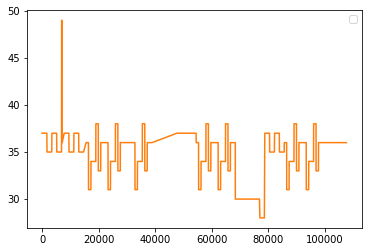

In [33]:
song = midi.read_midifile("4d76b33720ff81c50307ea73a7d3788b.mid_c5a8000e-5681-46a9-b3dc-08a6a158b415.mid")
song.make_ticks_abs()
tracks = []
for track in song:
    
    try:
        
        #if ("Words" not in track[0].text):
        #    continue
        print(track[0].text)
    except:
        pass
    
    notes = [note for note in track if note.name == 'Note On']
    pitch = [note.pitch for note in notes]
    tick = [note.tick for note in notes]
    tracks += [tick, pitch]
plt.plot(*tracks)
plt.legend()
plt.show()

In [34]:
song

midi.Pattern(format=1, resolution=220, tracks=\
[midi.Track(\
  [midi.TimeSignatureEvent(tick=0, data=[4, 2, 24, 8]),
   midi.SetTempoEvent(tick=0, data=[7, 161, 32]),
   midi.EndOfTrackEvent(tick=1, data=[])]),
 midi.Track(\
  [midi.ProgramChangeEvent(tick=0, channel=0, data=[38]),
   midi.ControlChangeEvent(tick=0, channel=0, data=[7, 121]),
   midi.ControlChangeEvent(tick=0, channel=0, data=[10, 90]),
   midi.NoteOnEvent(tick=0, channel=0, data=[37, 125]),
   midi.NoteOnEvent(tick=33, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=54, channel=0, data=[37, 108]),
   midi.NoteOnEvent(tick=76, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=108, channel=0, data=[37, 106]),
   midi.NoteOnEvent(tick=126, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=162, channel=0, data=[37, 127]),
   midi.NoteOnEvent(tick=189, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=216, channel=0, data=[37, 106]),
   midi.NoteOnEvent(tick=243, channel=0, data=[37, 0]),
   midi.NoteOnEvent(tick=27

In [93]:
pattern = midi.Pattern()
pattern.resolution = 480
track = midi.Track()
pattern.append(track)

track.append(midi.TimeSignatureEvent(tick=0, data=[4, 4, 1, 8]))
track.append(midi.SetTempoEvent(tick=0, data=[2, 0, 0]))

'''
n = midi.NoteOnEvent(tick=0, channel=0, data=[72, 20])
track.append(n)
n = midi.NoteOffEvent(tick=30, channel=0, data=[72, 20])
track.append(n)
n = midi.NoteOnEvent(tick=372, channel=0, data=[84, 20])
track.append(n)
n = midi.NoteOffEvent(tick=492, channel=0, data=[84, 20])
track.append(n)
n = midi.NoteOnEvent(tick=867, channel=0, data=[60, 20])
track.append(n)
n = midi.NoteOffEvent(tick=1107, channel=0, data=[60, 20])
track.append(n)

'''


t = 1107

for t in range(1107,100,20000):


    n = midi.NoteOnEvent(tick = t + 1, channel = 0, data=[86, 20])
    track.append(n)
    n = midi.NoteOffEvent(tick = t + 200, channel = 0, data=[86, 20])
    track.append(n)

eot = midi.EndOfTrackEvent(tick=1)
track.append(eot)





midi.write_midifile("ZZZ1.mid", pattern)

In [28]:
from midiutil import MIDIFile

degrees  = [60, 62, 64, 65, 67, 69, 71, 72]  # MIDI note number
track    = 0
channel  = 0
time     = 0    # In beats
duration = 1    # In beats
tempo    = 800  # In BPM
volume   = 100  # 0-127, as per the MIDI standard

MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                      # automatically)
MyMIDI.addTempo(track, time, tempo)


MyMIDI.addNote(track, channel, 63, 0, 1, volume)
MyMIDI.addNote(track, channel, 64, 1, 1, volume)
MyMIDI.addNote(track, channel, 63, 2, 1, volume)
MyMIDI.addNote(track, channel, 64, 3, 1, volume)
MyMIDI.addNote(track, channel, 62, 4, 16, volume)
MyMIDI.addNote(track, channel, 65, 20, 8, volume)
MyMIDI.addNote(track, channel, 66, 28, 4, volume)

with open("zzz.mid", "wb") as output_file:
    MyMIDI.writeFile(output_file)
    
# 1такт = xbeats
# в минуту сколько тактов? ну пусть 25
# тогда будет 25x BPM делить будем по 32-ой? тогда надо 32*25 = 800BPM
